### Prepare the data and a pretrained MNIST model

In [7]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from AdversarialAttack import FGSMTargeted
from models.mnist_model import Net


pretrained_model = "models/lenet_mnist_model.pth"
use_cuda= False  # Set this to True to use CUDA if available
torch.manual_seed(42)

cuda_available = torch.cuda.is_available()
if use_cuda:
    print("CUDA Available: ", cuda_available)
device = torch.device("cuda" if use_cuda and cuda_available else "cpu")

print("Device: ", device)

Device:  cpu


In [8]:
# Define MNIST test set dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),])), batch_size=1)

Load the pretrained MNIST model (could be any PyTorch model):


In [9]:

model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location=device, weights_only=True))

# Set the model in evaluation mode for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Use FGSMAttack class to perform a targeted adversarial attack

In [10]:
# Define any target class for the attack
target_class = 8

In [11]:
# Create an instance of the FGSMTargeted attack class
fgsm = FGSMTargeted(model, device)


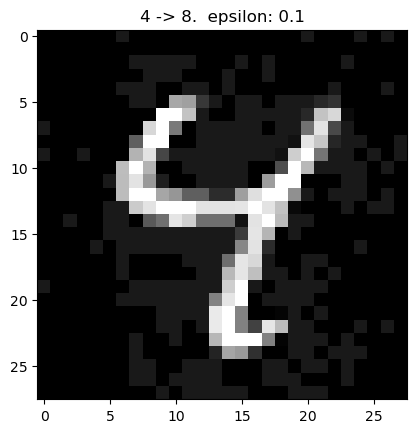

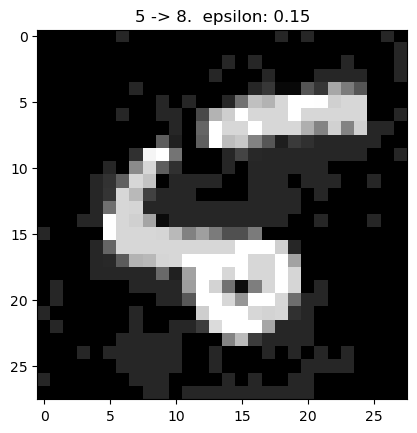

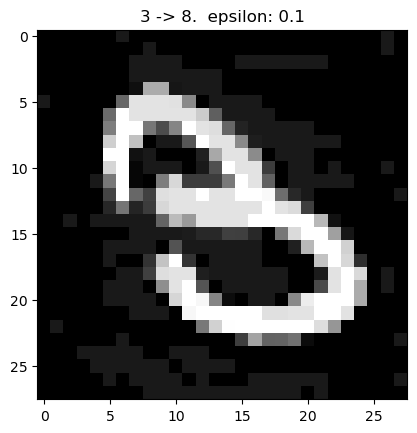

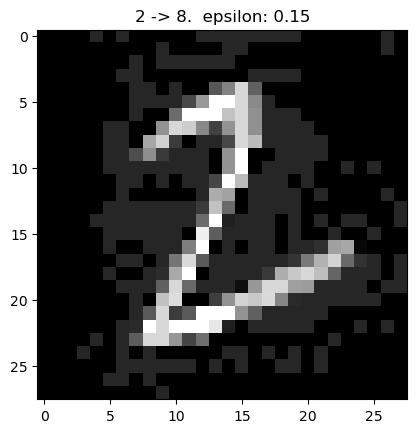

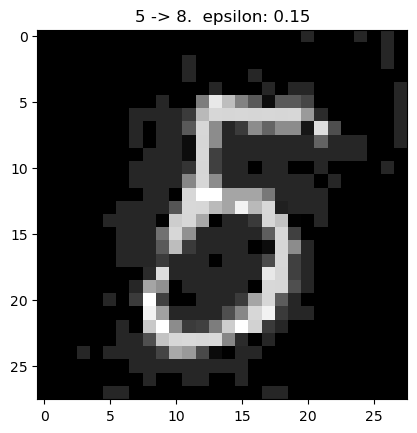

In [12]:
# Apply the attack to first 50 sample images from the test dataset.
for batch_idx, (data, label) in enumerate(test_loader):
    if batch_idx >= 50:
        break
    perturbed_data, attack_is_successful, adv_pred, attack_epsilon = fgsm.generate_adv_example(data, target_class)
    if attack_is_successful:
        plt.imshow(perturbed_data.squeeze().detach().cpu().numpy(), cmap="gray")
        plt.title(f"{label.item()} -> {adv_pred.item()}.  epsilon: {attack_epsilon}")
        plt.show()
